In [1]:
import os
import re
import math
import glob
from importlib import reload

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import osu.rulesets.beatmap as bm
import osu.rulesets.replay as rp
import osu.rulesets.hitobjects as hitobjects
import osu.dataset as dataset

import osu.preview.preview as preview

Rust acceleration available!
pygame 2.6.1 (SDL 2.28.4, Python 3.13.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


E:\Projects\osu\.venv\Lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


In [ ]:
obj_dataset = dataset.replay_mapping_from_cache(10000)

In [18]:
obj_dataset

,replay,beatmap
0,<osu.rulesets.replay._convert_rust_replay.<loc...,<osu.rulesets.beatmap._convert_rust_beatmap.<l...
1,<osu.rulesets.replay._convert_rust_replay.<loc...,<osu.rulesets.beatmap._convert_rust_beatmap.<l...
2,<osu.rulesets.replay._convert_rust_replay.<loc...,<osu.rulesets.beatmap._convert_rust_beatmap.<l...
3,<osu.rulesets.replay._convert_rust_replay.<loc...,<osu.rulesets.beatmap._convert_rust_beatmap.<l...
4,<osu.rulesets.replay._convert_rust_replay.<loc...,<osu.rulesets.beatmap._convert_rust_beatmap.<l...
...,...,...
4425,<osu.rulesets.replay._convert_rust_replay.<loc...,<osu.rulesets.beatmap._convert_rust_beatmap.<l...
4426,<osu.rulesets.replay._convert_rust_replay.<loc...,<osu.rulesets.beatmap._convert_rust_beatmap.<l...
4427,<osu.rulesets.replay._convert_rust_replay.<loc...,<osu.rulesets.beatmap._convert_rust_beatmap.<l...
4428,<osu.rulesets.replay._convert_rust_replay.<loc...,<osu.rulesets.beatmap._convert_rust_beatmap.<l...


In [19]:
input_data = dataset.input_data(obj_dataset, verbose=True)
output_data = dataset.target_data(obj_dataset, verbose=True)

Turning replays into time series data: 100%|██████████| 4430/4430 [01:50<00:00, 39.97it/s]


In [20]:
input = input_data
output = output_data

In [21]:
input

x           y  visible  is_slider  is_spinner
chunk frame                                                        
0     0      255.500000  191.500000      0.0        0.0         0.0
      1        0.386719    0.182292      1.0        1.0         0.0
      2        0.386719    0.182292      1.0        1.0         0.0
      3        0.386719    0.182292      1.0        1.0         0.0
      4        0.386719    0.182292      1.0        1.0         0.0
...                 ...         ...      ...        ...         ...
19397 2043     0.000000    0.000000      0.0        0.0         0.0
      2044     0.000000    0.000000      0.0        0.0         0.0
      2045     0.000000    0.000000      0.0        0.0         0.0
      2046     0.000000    0.000000      0.0        0.0         0.0
      2047     0.000000    0.000000      0.0        0.0         0.0

[39727104 rows x 5 columns]

In [22]:
import torch

xs = np.reshape(input.values, (-1, dataset.BATCH_LENGTH, len(dataset.INPUT_FEATURES)))

# try:
#     target_data = pd.read_pickle('.data/target_data.dat')
# except:
#     target_data = dataset.target_data(dataset, verbose=True)
#     target_data.to_pickle('.data/target_data.dat')

ys = np.reshape(output.values, (-1, dataset.BATCH_LENGTH, len(dataset.OUTPUT_FEATURES)))

xs.shape

(19398, 2048, 5)

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from random import randint 
from torch.utils.data import DataLoader, TensorDataset

EPOCHS = 100
BATCH_SIZE = 64

x_train, x_test, y_train, y_test = train_test_split(xs, ys, test_size=0.2, random_state=randint(0, 100))

train_dataset = TensorDataset(torch.FloatTensor(x_train), torch.FloatTensor(y_train))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [24]:

# punish for not smooth movements
# class VelocityAwareLoss(nn.Module):
#     def __init__(self, position_weight=1.0, velocity_weight=0.3):
#         super().__init__()
#         self.pos_weight = position_weight
#         self.vel_weight = velocity_weight
#         
#     def forward(self, pred, target):
#         # Position loss
#         pos_loss = F.mse_loss(pred, target)
#         
#         # Velocity loss (differences between consecutive timesteps)
#         pred_vel = pred[:, 1:] - pred[:, :-1]
#         target_vel = target[:, 1:] - target[:, :-1]
#         vel_loss = F.mse_loss(pred_vel, target_vel)
#         
#         return self.pos_weight * pos_loss + self.vel_weight * vel_loss

class OsuModel(nn.Module):
    def __init__(self, input_size, output_size, noise_std=0.2):
        super(OsuModel, self).__init__()
        
        self.lstm = nn.LSTM(input_size, 64, batch_first=True)
        self.dense1 = nn.Linear(64, 64)
        self.noise_std = noise_std
        self.dense2 = nn.Linear(64, 16)
        self.position = nn.Linear(16, output_size)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        
        pos = self.dense1(lstm_out)
        
        # gaussian noise (only applied during training)
        if self.training:
            noise = torch.randn_like(pos) * self.noise_std
            pos = pos + noise
        
        pos = self.dense2(pos)
        pos = self.position(pos)
        
        return pos

input_size = xs.shape[2]  # feature dimension
output_size = ys.shape[2]  # output dimension

model = OsuModel(input_size, output_size)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
criterion = torch.nn.SmoothL1Loss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.load_state_dict(torch.load(".trained/most_recent.pt"))
print(model)
print(f"Total parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

OsuModel(
  (lstm): LSTM(5, 64, batch_first=True)
  (dense1): Linear(in_features=64, out_features=64, bias=True)
  (dense2): Linear(in_features=64, out_features=16, bias=True)
  (position): Linear(in_features=16, out_features=2, bias=True)
)
Total parameters: 23410


In [25]:
epoch_losses = []

In [26]:
import tqdm

for epoch in range(EPOCHS):
    epoch_loss = 0
    for batch_x, batch_y in tqdm.tqdm(train_loader):
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        # print(batch_x.shape)
        # print(batch_y.shape)
        optimizer.zero_grad()
        outputs = model(batch_x)
        
        loss = criterion(outputs, batch_y)
        loss.backward()
        
        optimizer.step()

        epoch_loss += loss.item()
    epoch_loss = epoch_loss/len(train_loader)
    print(f'Epoch {epoch+1}/{EPOCHS}, Loss: {epoch_loss:.4f}')
    epoch_losses.append(epoch_loss)
    

100%|██████████| 243/243 [00:03<00:00, 62.18it/s]


Epoch 1/100, Loss: 0.0016


100%|██████████| 243/243 [00:03<00:00, 70.90it/s]


Epoch 2/100, Loss: 0.0016


100%|██████████| 243/243 [00:03<00:00, 75.44it/s]


Epoch 3/100, Loss: 0.0016


100%|██████████| 243/243 [00:03<00:00, 74.07it/s]


Epoch 4/100, Loss: 0.0016


100%|██████████| 243/243 [00:03<00:00, 69.74it/s]


Epoch 5/100, Loss: 0.0016


100%|██████████| 243/243 [00:03<00:00, 71.86it/s]


Epoch 6/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 59.42it/s]


Epoch 7/100, Loss: 0.0015


100%|██████████| 243/243 [00:03<00:00, 64.69it/s]


Epoch 8/100, Loss: 0.0015


100%|██████████| 243/243 [00:03<00:00, 72.50it/s]


Epoch 9/100, Loss: 0.0015


100%|██████████| 243/243 [00:03<00:00, 76.11it/s]


Epoch 10/100, Loss: 0.0015


100%|██████████| 243/243 [00:03<00:00, 76.15it/s]


Epoch 11/100, Loss: 0.0015


100%|██████████| 243/243 [00:03<00:00, 74.04it/s]


Epoch 12/100, Loss: 0.0015


100%|██████████| 243/243 [00:03<00:00, 75.93it/s]


Epoch 13/100, Loss: 0.0015


100%|██████████| 243/243 [00:03<00:00, 68.16it/s]


Epoch 14/100, Loss: 0.0015


100%|██████████| 243/243 [00:03<00:00, 69.90it/s]


Epoch 15/100, Loss: 0.0015


100%|██████████| 243/243 [00:03<00:00, 67.04it/s]


Epoch 16/100, Loss: 0.0015


100%|██████████| 243/243 [00:03<00:00, 66.26it/s]


Epoch 17/100, Loss: 0.0015


100%|██████████| 243/243 [00:03<00:00, 68.78it/s]


Epoch 18/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 60.05it/s]


Epoch 19/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 57.89it/s]


Epoch 20/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 53.82it/s]


Epoch 21/100, Loss: 0.0015


100%|██████████| 243/243 [00:03<00:00, 61.81it/s]


Epoch 22/100, Loss: 0.0015


100%|██████████| 243/243 [00:03<00:00, 64.77it/s]


Epoch 23/100, Loss: 0.0015


100%|██████████| 243/243 [00:03<00:00, 66.36it/s]


Epoch 24/100, Loss: 0.0015


100%|██████████| 243/243 [00:03<00:00, 67.31it/s]


Epoch 25/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 58.92it/s]


Epoch 26/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 59.11it/s]


Epoch 27/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 60.01it/s]


Epoch 28/100, Loss: 0.0015


100%|██████████| 243/243 [00:03<00:00, 64.63it/s]


Epoch 29/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 55.63it/s]


Epoch 30/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 58.51it/s]


Epoch 31/100, Loss: 0.0015


100%|██████████| 243/243 [00:03<00:00, 60.82it/s]


Epoch 32/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 59.98it/s]


Epoch 33/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 59.72it/s]


Epoch 34/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 59.85it/s]


Epoch 35/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 59.08it/s]


Epoch 36/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 58.59it/s]


Epoch 37/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 59.26it/s]


Epoch 38/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 58.35it/s]


Epoch 39/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 57.68it/s]


Epoch 40/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 59.52it/s]


Epoch 41/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 58.59it/s]


Epoch 42/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 57.40it/s]


Epoch 43/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 57.21it/s]


Epoch 44/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 57.67it/s]


Epoch 45/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 56.74it/s]


Epoch 46/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 56.74it/s]


Epoch 47/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 56.12it/s]


Epoch 48/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 56.73it/s]


Epoch 49/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 57.25it/s]


Epoch 50/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 56.41it/s]


Epoch 51/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 57.31it/s]


Epoch 52/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 56.29it/s]


Epoch 53/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 57.87it/s]


Epoch 54/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 57.65it/s]


Epoch 55/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 57.47it/s]


Epoch 56/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 58.08it/s]


Epoch 57/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 58.10it/s]


Epoch 58/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 58.39it/s]


Epoch 59/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 57.11it/s]


Epoch 60/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 53.69it/s]


Epoch 61/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 57.84it/s]


Epoch 62/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 57.05it/s]


Epoch 63/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 55.05it/s]


Epoch 64/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 56.67it/s]


Epoch 65/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 56.79it/s]


Epoch 66/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 56.52it/s]


Epoch 67/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 54.84it/s]


Epoch 68/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 56.52it/s]


Epoch 69/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 57.20it/s]


Epoch 70/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 56.59it/s]


Epoch 71/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 55.97it/s]


Epoch 72/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 56.90it/s]


Epoch 73/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 57.17it/s]


Epoch 74/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 56.97it/s]


Epoch 75/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 57.03it/s]


Epoch 76/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 60.17it/s]


Epoch 77/100, Loss: 0.0015


100%|██████████| 243/243 [00:03<00:00, 67.92it/s]


Epoch 78/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 58.38it/s]


Epoch 79/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 58.09it/s]


Epoch 80/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 57.80it/s]


Epoch 81/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 57.07it/s]


Epoch 82/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 57.14it/s]


Epoch 83/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 57.30it/s]


Epoch 84/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 57.89it/s]


Epoch 85/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 57.30it/s]


Epoch 86/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 57.32it/s]


Epoch 87/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 56.29it/s]


Epoch 88/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 56.33it/s]


Epoch 89/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 56.97it/s]


Epoch 90/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 57.02it/s]


Epoch 91/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 57.27it/s]


Epoch 92/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 57.39it/s]


Epoch 93/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 58.88it/s]


Epoch 94/100, Loss: 0.0015


100%|██████████| 243/243 [00:03<00:00, 65.84it/s]


Epoch 95/100, Loss: 0.0015


100%|██████████| 243/243 [00:03<00:00, 61.27it/s]


Epoch 96/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 55.26it/s]


Epoch 97/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 54.55it/s]


Epoch 98/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 56.14it/s]


Epoch 99/100, Loss: 0.0015


100%|██████████| 243/243 [00:04<00:00, 56.50it/s]

Epoch 100/100, Loss: 0.0015


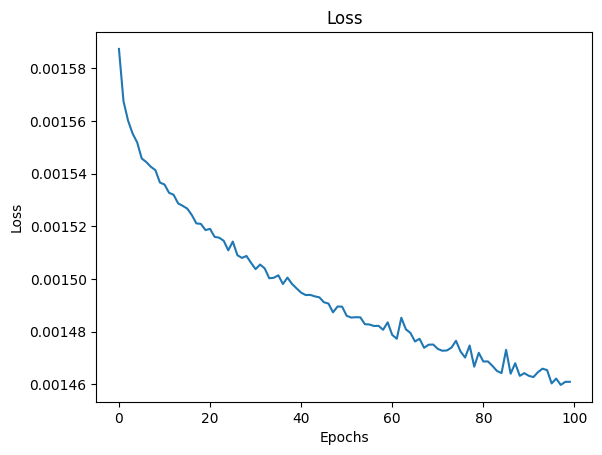

In [27]:
import matplotlib.pyplot as plt

plt.plot(epoch_losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss")
plt.show()

if not os.path.exists('.trained'):
    os.makedirs('.trained')

import datetime
now = datetime.datetime.now()
torch.save(model.state_dict(), f'.trained/{now.strftime("%Y-%m-%d_%H-%M-%S")}.pt')
torch.save(model.state_dict(), f'.trained/most_recent.pt')

In [34]:
import osu.rulesets.beatmap as bm
import osu.rulesets.replay as rp
import osu.dataset as dataset

test_name = 'moonmen'

test_map = f'assets/{test_name}_map.osu'
test_song = f'assets/{test_name}_song.mp3'

test_map = bm.load(test_map)

data = dataset.input_data(test_map)
data = np.reshape(data.values, (-1, dataset.BATCH_LENGTH, len(dataset.INPUT_FEATURES)))
data = torch.FloatTensor(data).to(device)

Turning beatmaps into time series data: 100%|██████████| 1/1 [00:00<00:00, 53.29it/s]


In [35]:
with torch.no_grad():
    replay_data = model(data).to('cpu').numpy()
    
replay_data = np.concatenate(replay_data)
if not os.path.exists('.generated'):
    os.makedirs('.generated')
    
np.save('.generated\\' + test_name + '.npy', replay_data)

In [36]:
import osu.preview.preview as preview

preview.preview_replay(replay_data, test_map, test_song)